In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
%matplotlib inline
import pickle

#import keras
#from keras.layers import Activation, Dense, Conv1D, Conv2D, MaxPooling1D, Flatten, Reshape, Dropout
#from keras.models import Sequential

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import tensorflow_io as tfio

from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)
else:
    print('no gpu')


In [3]:
#features = pd.read_csv('data/features.csv', index_col=0, header=[0, 1, 2])
fma_single = pickle.load(open("saved/fma_single.p", "rb"))

In [4]:
fma_multi=pickle.load(open("saved/fma_multi.p","rb"))

In [5]:
fma_single

,split,subset,filepath,genre_top
track_id,,,,
2,training,small,data/fma_large/000/000002.mp3,Hip-Hop
3,training,medium,data/fma_large/000/000003.mp3,Hip-Hop
5,training,small,data/fma_large/000/000005.mp3,Hip-Hop
10,training,small,data/fma_large/000/000010.mp3,Pop
134,training,medium,data/fma_large/000/000134.mp3,Hip-Hop
...,...,...,...,...
155315,training,large,data/fma_large/155/155315.mp3,Rock
155316,training,large,data/fma_large/155/155316.mp3,Rock
155317,training,large,data/fma_large/155/155317.mp3,Rock


For the baseline model we are going to use the 'small' set of 8000 tracks in 8 classes, and train the model on the mfccs of the tracks which we extracted earlier.

In [6]:
#load mfccs
mfcc_df=pickle.load(open("saved/mfcc_small.p","rb"))

In [7]:
mfcc_df.shape

(7997, 23232)

In [8]:
mfcc_df.head()

,0,1,2,3,4,5,6,7,8,9,...,23222,23223,23224,23225,23226,23227,23228,23229,23230,23231
2,-299.542053,-202.513412,-159.976059,-115.456413,-80.415161,-67.523239,-57.689404,-65.464790,-84.703659,-96.179939,...,-5.861199,-4.460218,-6.887738,-7.665272,6.717929,12.769140,11.439809,9.167293,7.916427,5.665779
5,-324.059723,-227.421249,-186.883606,-158.489868,-94.902466,-95.517578,-106.146324,-70.498611,-45.091522,-41.156029,...,-6.403229,-4.675876,5.932048,19.163589,24.138350,12.146925,1.931949,-0.370714,1.137535,-0.625799
10,-71.376122,-32.296730,-29.356266,-38.037708,-44.881695,-45.910717,-31.081173,8.275231,28.077381,6.006516,...,9.814901,0.409050,-6.546686,-4.728213,-2.329597,4.121199,8.337200,8.429386,10.133602,11.033691
140,-561.324280,-523.545837,-449.814423,-342.445557,-306.727356,-308.809631,-307.733276,-317.345245,-362.774811,-419.306946,...,1.818927,3.912658,4.593844,2.139801,-4.394735,-5.267244,-6.697974,-5.783470,-5.886441,-3.706590
141,-464.980743,-371.434326,-330.917175,-342.813904,-362.013550,-368.364441,-361.755188,-358.438049,-365.668640,-375.685730,...,0.601643,-0.995060,0.146230,3.676285,-1.177926,-2.822582,4.884428,3.736303,2.701882,-2.805002


In [9]:
mfcc_df.replace([np.inf, -np.inf], np.nan)

,0,1,2,3,4,5,6,7,8,9,...,23222,23223,23224,23225,23226,23227,23228,23229,23230,23231
2,-299.542053,-202.513412,-159.976059,-115.456413,-80.415161,-67.523239,-57.689404,-65.464790,-84.703659,-96.179939,...,-5.861199,-4.460218,-6.887738,-7.665272,6.717929,12.769140,11.439809,9.167293,7.916427,5.665779
5,-324.059723,-227.421249,-186.883606,-158.489868,-94.902466,-95.517578,-106.146324,-70.498611,-45.091522,-41.156029,...,-6.403229,-4.675876,5.932048,19.163589,24.138350,12.146925,1.931949,-0.370714,1.137535,-0.625799
10,-71.376122,-32.296730,-29.356266,-38.037708,-44.881695,-45.910717,-31.081173,8.275231,28.077381,6.006516,...,9.814901,0.409050,-6.546686,-4.728213,-2.329597,4.121199,8.337200,8.429386,10.133602,11.033691
140,-561.324280,-523.545837,-449.814423,-342.445557,-306.727356,-308.809631,-307.733276,-317.345245,-362.774811,-419.306946,...,1.818927,3.912658,4.593844,2.139801,-4.394735,-5.267244,-6.697974,-5.783470,-5.886441,-3.706590
141,-464.980743,-371.434326,-330.917175,-342.813904,-362.013550,-368.364441,-361.755188,-358.438049,-365.668640,-375.685730,...,0.601643,-0.995060,0.146230,3.676285,-1.177926,-2.822582,4.884428,3.736303,2.701882,-2.805002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154308,-313.429077,-285.330048,-283.423401,-287.088348,-289.263672,-184.150192,-41.746201,-12.892635,-55.076210,-115.045479,...,10.231204,11.211655,0.058539,-11.264427,-6.596434,4.120525,6.856134,5.343898,2.773130,1.698187
154309,-486.301819,-482.713928,-496.109802,-501.279755,-502.606598,-506.784668,-509.464905,-310.994598,-145.997116,-127.237030,...,-3.249464,-10.734337,-11.473764,-8.660153,-7.335606,-11.601185,-16.454685,-15.517137,-11.830728,-11.240954
154413,-155.809250,-137.494919,-114.974205,-140.923645,-162.126450,-160.300812,-160.252792,-164.502640,-163.036118,-166.671722,...,-16.811752,-17.902248,-22.706905,-22.197693,-24.581553,-25.488754,-21.233810,-23.033970,-21.506649,-22.316118
154414,-157.556030,-162.392120,-172.492035,-185.008377,-195.222931,-197.421844,-194.316422,-151.761810,-53.744122,0.694292,...,-14.949778,-13.652007,-14.656978,-12.779702,-15.503021,-17.758909,-18.673512,-14.957970,-11.633366,-14.272188


In [10]:
mfcc_df.fillna(method='ffill',inplace=True)

In [11]:
#use the 8000 track balanced subset for baseline modeling

drop3=pickle.load(open("saved/drop3.p","rb"))
fma_single.drop(drop3, inplace=True)
subset = fma_single.index[fma_single['subset'] == 'small']

In [12]:
fma_small=fma_single.loc[subset]

In [13]:
mfcc_sub=mfcc_df.loc[subset]

In [14]:
#use the built in train/test/validation split in case we want to compare to other models over this dataset
train = fma_small.index[fma_small['split'] == 'training']
val = fma_small.index[fma_small['split'] == 'validation']
test = fma_small.index[fma_small['split'] == 'test']

In [15]:
print(len(train),len(val),len(test))

6310 793 794


In [16]:
#preprocessing single label

#enc=MultiLabelBinarizer()
enc=LabelEncoder()
labels=fma_small['genre_top']
#labels=y_df

# Split in training, validation and testing sets.

#single label
y_train = enc.fit_transform(labels[train])
y_val = enc.transform(labels[val])
y_test = enc.transform(labels[test])
#y_train = track_sub['label']

X_train = mfcc_sub.loc[train].values
X_val = mfcc_sub.loc[val].values
X_test = mfcc_sub.loc[test].values
    
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [17]:
# Standardize features
scaler = StandardScaler(copy=False)
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [18]:
X_train.shape

(6310, 23232)

In [29]:
keras.backend.clear_session()

#define CNN-LSTM
model = models.Sequential()

model.add(layers.Reshape((726,16,2),input_shape=(X_train.shape[1],)))
model.add(layers.TimeDistributed(layers.Conv1D(64, 3, activation='relu')))
model.add(layers.TimeDistributed(layers.MaxPooling1D(2)))
model.add(layers.TimeDistributed(layers.Conv1D(128, 3, activation='relu')))

model.add(layers.TimeDistributed(layers.Conv1D(128, 3, activation='relu')))
model.add(layers.TimeDistributed(layers.MaxPooling1D(2)))
model.add(layers.TimeDistributed(layers.Dropout(.2)))
model.add(layers.TimeDistributed(layers.Flatten()))

#model.add(layers.LSTM(units=128, dropout=0.2, return_sequences=True))
model.add(layers.LSTM(units=64, dropout=0.2, return_sequences=False))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(.2))
model.add(layers.Dense(8, activation='softmax'))

loss=tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer='adam',
              loss=loss,
              metrics=['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 726, 16, 2)        0         
_________________________________________________________________
time_distributed (TimeDistri (None, 726, 14, 64)       448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 726, 7, 64)        0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 726, 5, 128)       24704     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 726, 3, 128)       49280     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 726, 1, 128)       0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 726, 1, 128)       0

In [31]:
%%time
with tf.device('/GPU:0'):
    history=model.fit(X_train,
              y_train,
              epochs=50,
              batch_size=64,
              validation_data=(X_val, y_val))

Epoch 1/50
99/99 [==============================] - 21s 208ms/step - loss: 1.9763 - accuracy: 0.2124 - val_loss: 1.8962 - val_accuracy: 0.2699
Epoch 2/50
99/99 [==============================] - 20s 202ms/step - loss: 1.9727 - accuracy: 0.2254 - val_loss: 1.9011 - val_accuracy: 0.2610
Epoch 3/50
99/99 [==============================] - 20s 204ms/step - loss: 1.9956 - accuracy: 0.2052 - val_loss: 1.9544 - val_accuracy: 0.2270
Epoch 4/50
99/99 [==============================] - 20s 207ms/step - loss: 1.9646 - accuracy: 0.2195 - val_loss: 1.8694 - val_accuracy: 0.2699
Epoch 5/50
99/99 [==============================] - 20s 206ms/step - loss: 1.9246 - accuracy: 0.2480 - val_loss: 1.8537 - val_accuracy: 0.3014
Epoch 6/50
99/99 [==============================] - 20s 201ms/step - loss: 1.9388 - accuracy: 0.2401 - val_loss: 1.8768 - val_accuracy: 0.2623
Epoch 7/50
99/99 [==============================] - 20s 201ms/step - loss: 1.8725 - accuracy: 0.2769 - val_loss: 1.7935 - val_accuracy: 0.3165

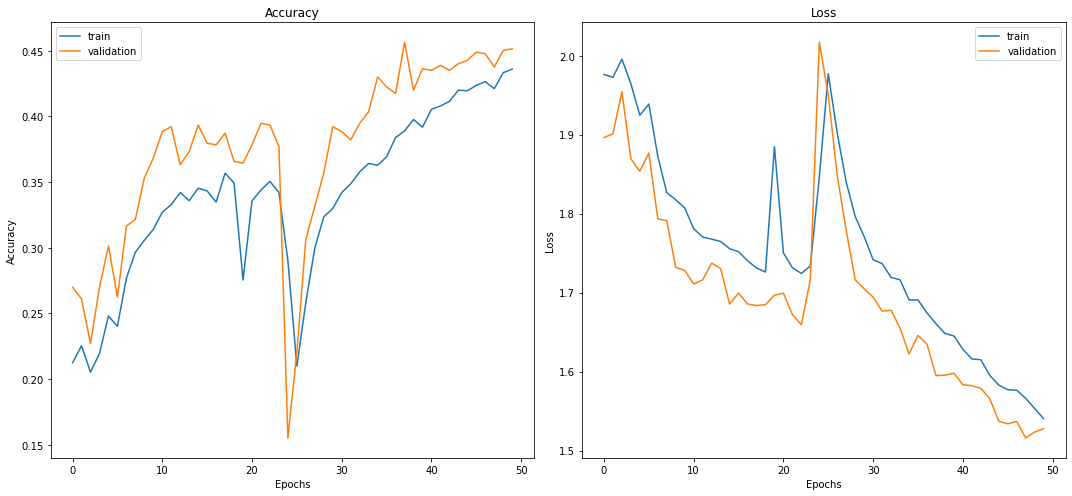

In [32]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [34]:
#make clear this is test set
y_pred=model.predict_classes(X_test)
print('Classification Report (test set)')
print(classification_report(y_test,y_pred))

Classification Report (test set)
              precision    recall  f1-score   support

           0       0.36      0.39      0.37        96
           1       0.27      0.14      0.19        98
           2       0.24      0.30      0.27       100
           3       0.42      0.57      0.48       100
           4       0.25      0.16      0.20       100
           5       0.33      0.38      0.36       100
           6       0.28      0.19      0.23       100
           7       0.42      0.56      0.48       100

    accuracy                           0.34       794
   macro avg       0.32      0.34      0.32       794
weighted avg       0.32      0.34      0.32       794



Over the set of:  
* 8 classes
* 1000 samples each class

The CNN-LSTM model shows a modest improvement over both the CNN and LSTM models

| Model | Accuracy(all classes) | Train Time |
| --- | --- | --- |
| CNN | .38 | 15m |
| LSTM | .34 | 90m |
| CNN-LSTM | .36 | 5m |
